# Colab Step‑by‑Step: Recommendation Model (MovieLens 100K)
This notebook pins NumPy <2 to keep Surprise compatible.
Run cells top‑to‑bottom.

## 0) Install exact dependencies (NumPy <2, Surprise)

In [2]:
# Install numpy, surprise, pandas, mtplotlib versions that can work together
# to resolve Google Colab dependencies
!pip -q install "numpy<2.0" scikit-surprise pandas matplotlib

## 1) Imports and environment check

In [1]:
# --- Step 1: Colab environment fix for Surprise ---
# Surprise (the recommender library) is not yet compatible with NumPy >= 2.0.
# This setup block ensures the Colab runtime has compatible versions of NumPy
# and related dependencies, and cleans out any conflicting packages.

import os, sys, subprocess, platform

# Helper function to call pip programmatically from within Python.
# This avoids shell escapes ("!pip") and works more reliably in notebooks.
def pip(*args):
    subprocess.check_call([sys.executable, "-m", "pip", *args])

# --- Check if environment needs fixing ---
need_fix = False
try:
    # Try to import NumPy and check its version
    import numpy as _np
    # If major version >= 2, we need to fix
    need_fix = tuple(map(int, _np.__version__.split(".")[:2])) >= (2, 0)
except Exception:
    # If import fails entirely, also trigger fix
    need_fix = True

if need_fix:
    # Remove packages that are tied to NumPy 2 wheels and cause ABI conflicts.
    pip("uninstall", "-y", "opencv-python", "opencv-contrib-python",
        "opencv-python-headless", "thinc", "spacy")

    # Install compatible versions explicitly pinned to work with Surprise.
    # This ensures consistent builds and avoids dependency mismatches.
    pip("install", "--upgrade", "--force-reinstall",
        "numpy==1.26.4", "pandas==2.1.4", "scipy==1.11.4",
        "matplotlib==3.8.4", "scikit-surprise==1.1.3")

    # Force the process to restart so the new binaries are loaded cleanly.
    os.kill(os.getpid(), 9)

# --- Safe imports after potential restart ---
# At this point, we know NumPy < 2.0 and Surprise should import cleanly.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split

# Print environment diagnostics: Python version, NumPy version, platform.
print("Python:", sys.version.split(" ")[0],
      "| NumPy:", np.__version__,
      "| Platform:", platform.platform())

# Assert again that NumPy is < 2.0; fail fast if not.
assert tuple(map(int, np.__version__.split(".")[:2])) < (2, 0), \
    "NumPy must be <2.0 for Surprise wheels."

Python: 3.12.11 | NumPy: 1.26.4 | Platform: Linux-6.1.123+-x86_64-with-glibc2.35


## 2) Dataset: MovieLens 100K (ratings and item titles)

In [2]:
# --- Step 2: Robust data load (handles SSL issues and local fallback) ---

# Define dataset URLs (MovieLens 100K). We try HTTPS first, then fallback to HTTP.
HTTPS = "https://files.grouplens.org/datasets/movielens/ml-100k/"
HTTP  = "http://files.grouplens.org/datasets/movielens/ml-100k/"

# Function: load_movielens_min
# ----------------------------------------
# Loads the minimal MovieLens 100K data needed for modeling:
#   - Ratings table: user_id, item_id, rating, timestamp
#   - Items table:   item_id, title
# Strategy:
#   1. Try loading via HTTPS, then HTTP.
#   2. If both fail, fall back to Surprise’s cached local copy.
# Returns:
#   r : DataFrame with ratings
#   i : DataFrame with minimal item metadata (IDs and titles only)
def load_movielens_min():
    names = ['user_id','item_id','rating','timestamp']
    for base in (HTTPS, HTTP):
        try:
            # Load ratings file (u.data is tab-separated with no headers)
            r = pd.read_csv(base+'u.data', sep='\t', header=None, names=names)

            # Load items file (u.item is pipe-separated; here we only need ID + title)
            i = pd.read_csv(base+'u.item', sep='|', header=None, encoding='latin-1',
                            usecols=[0,1], names=['item_id','title'])

            # Ensure item_id is integer type for reliable joins
            i['item_id'] = i['item_id'].astype(int)

            # If both reads succeed, return ratings and items
            return r, i
        except Exception:
            # If this attempt fails (e.g., SSL/network issues), try the next URL
            pass

    # If both HTTPS and HTTP failed, fall back to Surprise’s cached local copy
    Dataset.load_builtin('ml-100k')
    base = os.path.expanduser('~/.surprise_data/ml-100k/')

    # Load ratings from local cache
    r = pd.read_csv(os.path.join(base, 'u.data'), sep='\t', header=None, names=names)

    # Load item IDs and titles from local cache
    i = pd.read_csv(os.path.join(base, 'u.item'), sep='|', header=None, encoding='latin-1',
                    usecols=[0,1], names=['item_id','title'])

    # Convert item_id to integer
    i['item_id'] = i['item_id'].astype(int)

    return r, i


# Function: load_items_full
# ----------------------------------------
# Loads the full MovieLens 100K item metadata:
#   - Basic info: item_id, title, release_date, video_release_date, imdb_url
#   - 19 binary genre flags
# Strategy:
#   1. Try HTTPS, then HTTP.
#   2. If both fail, load from Surprise’s cached copy.
# Cleans:
#   - item_id as integer
#   - release dates parsed as datetime
#   - genre flags converted to boolean
# Returns:
#   df : DataFrame with full item metadata
def load_items_full():
    item_cols = [
      'item_id','title','release_date','video_release_date','imdb_url',
      'unknown','Action','Adventure','Animation','Children','Comedy','Crime',
      'Documentary','Drama','Fantasy','Film-Noir','Horror','Musical',
      'Mystery','Romance','Sci-Fi','Thriller','War','Western'
    ]
    for base in (HTTPS, HTTP):
        try:
            # Load the full items metadata file with all columns
            df = pd.read_csv(base+'u.item', sep='|', header=None, encoding='latin-1', names=item_cols)
            break
        except Exception:
            # If loading fails, try the next option
            df = None

    if df is None:
        # Fall back to Surprise’s cached local copy
        Dataset.load_builtin('ml-100k')
        base = os.path.expanduser('~/.surprise_data/ml-100k/')

        # Load full metadata from cache
        df = pd.read_csv(os.path.join(base, 'u.item'), sep='|', header=None, encoding='latin-1', names=item_cols)

    # Ensure item_id is stored as integer
    df['item_id'] = df['item_id'].astype(int)

    # Parse release_date, coercing invalid values to NaT
    df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

    # Parse video_release_date as datetime too
    df['video_release_date'] = pd.to_datetime(df['video_release_date'], errors='coerce')

    # Identify genre columns (all columns after index 5)
    genre_cols = item_cols[5:]

    # Fill missing genre values with 0, cast to int, then to boolean
    # (so each genre flag is True/False instead of 0/1)
    df[genre_cols] = df[genre_cols].fillna(0).astype(int).astype(bool)

    return df


# --- Minimal frames for Surprise modeling ---
# Ratings and minimal item info (ID + title) are sufficient for Surprise algorithms.
ratings, items = load_movielens_min()

# Preview first few ratings rows to confirm data loaded correctly
ratings.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [3]:
# Step 2 — Robust load + EDA copies (preserves Surprise inputs)
import os, pandas as pd
from surprise import Dataset

# Create a copy of the ratings table specifically for EDA (Exploratory Data Analysis).
# This keeps the original `ratings` intact for Surprise modeling.
ratings_eda = ratings.copy()

# Convert the raw UNIX timestamp into a human-readable datetime.
# Adds a new column `rated_at` in UTC, making it easier to analyze temporal patterns
# (e.g., user activity over time, seasonality).
ratings_eda['rated_at'] = pd.to_datetime(ratings_eda['timestamp'], unit='s', utc=True)

# Load the full items metadata table, which includes rich details such as genre flags,
# release dates, and external IMDB URLs. This is useful for EDA and possible hybrid recommenders.
items_full = load_items_full()

# Prepare the minimal view for modeling (used later in Step 4).
# Surprise algorithms only require three columns: user_id, item_id, and rating.
ratings_model = ratings[['user_id','item_id','rating']].copy()

# Print out the column names of each dataset variant.
# This is a sanity check to confirm we’ve set up the right structures:
print("ratings cols:", ratings.columns.tolist())
print("ratings_model cols:", ratings_model.columns.tolist())
print("ratings_eda cols:", ratings_eda.columns.tolist())
print("items_full cols:", items_full.columns.tolist())

ratings cols: ['user_id', 'item_id', 'rating', 'timestamp']
ratings_model cols: ['user_id', 'item_id', 'rating']
ratings_eda cols: ['user_id', 'item_id', 'rating', 'timestamp', 'rated_at']
items_full cols: ['item_id', 'title', 'release_date', 'video_release_date', 'imdb_url', 'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


In [4]:
from IPython.display import display

# Print and display the first 10 rows of the ratings dataset (EDA copy).
# ratings_eda includes user_id, item_id, rating, timestamp, and rated_at.
# This gives us a quick sanity check: what do the raw user–item interactions look like?
print("Ratings (EDA) — first 10")
display(ratings_eda.head(10))

# Print and display the first 10 rows of the items metadata table.
# We select a subset of columns: ID, title, release_date, and imdb_url.
# This lets us inspect the movie catalog that ratings refer to, verifying IDs map correctly to movie titles and metadata.
print("Items — first 10")
display(items_full[['item_id','title','release_date','imdb_url']].head(10))


Ratings (EDA) — first 10


,user_id,item_id,rating,timestamp,rated_at
0,196,242,3,881250949,1997-12-04 15:55:49+00:00
1,186,302,3,891717742,1998-04-04 19:22:22+00:00
2,22,377,1,878887116,1997-11-07 07:18:36+00:00
3,244,51,2,880606923,1997-11-27 05:02:03+00:00
4,166,346,1,886397596,1998-02-02 05:33:16+00:00
5,298,474,4,884182806,1998-01-07 14:20:06+00:00
6,115,265,2,881171488,1997-12-03 17:51:28+00:00
7,253,465,5,891628467,1998-04-03 18:34:27+00:00
8,305,451,3,886324817,1998-02-01 09:20:17+00:00
9,6,86,3,883603013,1997-12-31 21:16:53+00:00


Items — first 10


,item_id,title,release_date,imdb_url
0,1,Toy Story (1995),1995-01-01,http://us.imdb.com/M/title-exact?Toy%20Story%2...
1,2,GoldenEye (1995),1995-01-01,http://us.imdb.com/M/title-exact?GoldenEye%20(...
2,3,Four Rooms (1995),1995-01-01,http://us.imdb.com/M/title-exact?Four%20Rooms%...
3,4,Get Shorty (1995),1995-01-01,http://us.imdb.com/M/title-exact?Get%20Shorty%...
4,5,Copycat (1995),1995-01-01,http://us.imdb.com/M/title-exact?Copycat%20(1995)
5,6,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,1995-01-01,http://us.imdb.com/Title?Yao+a+yao+yao+dao+wai...
6,7,Twelve Monkeys (1995),1995-01-01,http://us.imdb.com/M/title-exact?Twelve%20Monk...
7,8,Babe (1995),1995-01-01,http://us.imdb.com/M/title-exact?Babe%20(1995)
8,9,Dead Man Walking (1995),1995-01-01,http://us.imdb.com/M/title-exact?Dead%20Man%20...
9,10,Richard III (1995),1996-01-22,http://us.imdb.com/M/title-exact?Richard%20III...


## 3) Exploratory Data Analysis (EDA)

In [5]:
from scipy.stats import entropy

# Unique user count
n_users = ratings['user_id'].nunique()

# Unique item count
n_items = ratings['item_id'].nunique()

# Total number of ratings (rows)
n_ratings = len(ratings)

# Density of the user–item matrix
density = n_ratings / (n_users * n_items)

# Summary line with percent formatting for density
print(f"Users: {n_users}, Items: {n_items}, Ratings: {n_ratings}, Density: {density:.4%}")


# --- Entropy Calculations ---
# 1. Item popularity entropy (measures popularity skew)
item_counts = ratings['item_id'].value_counts()
p_item = item_counts / item_counts.sum()  # Convert to probability distribution
item_entropy = entropy(p_item, base=2)  # Shannon entropy in bits
max_item_entropy = np.log2(len(p_item))  # Max entropy = log2(# of items)
norm_item_entropy = item_entropy / max_item_entropy  # Normalize to [0,1]

print(f"Item rating entropy: {item_entropy:.4f} bits (Normalized: {norm_item_entropy:.2%})")


# 2. User activity entropy (measures engagement spread)
user_counts = ratings['user_id'].value_counts()
p_user = user_counts / user_counts.sum()
user_entropy = entropy(p_user, base=2)
max_user_entropy = np.log2(len(p_user))
norm_user_entropy = user_entropy / max_user_entropy

print(f"User rating entropy: {user_entropy:.4f} bits (Normalized: {norm_user_entropy:.2%})")


# 3. Rating value entropy (measures rating diversity: e.g., mostly 4-5 or balanced)
rating_counts = ratings['rating'].value_counts().sort_index()
p_rating = rating_counts / rating_counts.sum()
rating_entropy = entropy(p_rating, base=2)
max_rating_entropy = np.log2(len(p_rating))
norm_rating_entropy = rating_entropy / max_rating_entropy

print(f"Rating value entropy: {rating_entropy:.4f} bits (Normalized: {norm_rating_entropy:.2%})")

# Density explanation
print("\nDensity: ")
print("With 943 users and 1682 movies, there are about 1.59 million possible ratings. Only 100,000 exist which is just 6.3% coverage.")
print("This means the dataset is very sparse. ")

# Item rating entropy explanation
print("\nItem Rating Entropy:")
print("Entropy here measures how evenly distributed is item popularity")
print("The normalized value (90%) indicates that ratings are spread broadly across many movies rather than being concentrated in just a few blockbusters.")

# User rating entropy explanation
print("\nUser Rating Entropy:")
print("This measures spread of user activity. A 94% normalized entropy means no extreme skew toward a few “super-raters.")

# Rating value entropy explanation
print("\nRating Value Entropy:")
print("This measures diversity of actual rating values (1–5 scale). With 91% normalized entropy, ratings are well spread across the five values.")


Users: 943, Items: 1682, Ratings: 100000, Density: 6.3047%
Item rating entropy: 9.7064 bits (Normalized: 90.58%)
User rating entropy: 9.3490 bits (Normalized: 94.61%)
Rating value entropy: 2.1175 bits (Normalized: 91.20%)

Density: 
With 943 users and 1682 movies, there are about 1.59 million possible ratings. Only 100,000 exist which is just 6.3% coverage.
This means the dataset is very sparse. 

Item Rating Entropy:
Entropy here measures how evenly distributed is item popularity
The normalized value (90%) indicates that ratings are spread broadly across many movies rather than being concentrated in just a few blockbusters.

User Rating Entropy:
This measures spread of user activity. A 94% normalized entropy means no extreme skew toward a few “super-raters.

Rating Value Entropy:
This measures diversity of actual rating values (1–5 scale). With 91% normalized entropy, ratings are well spread across the five values.


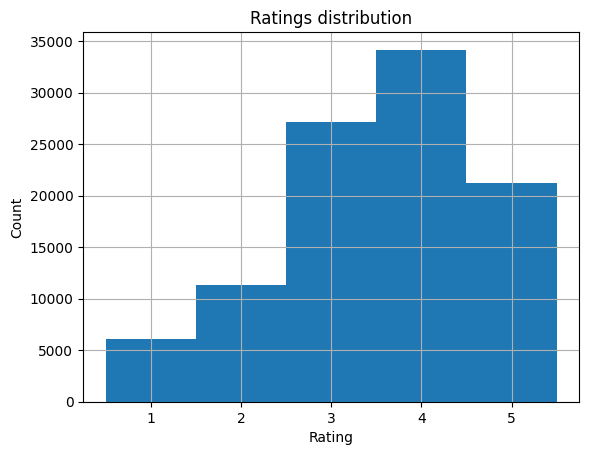

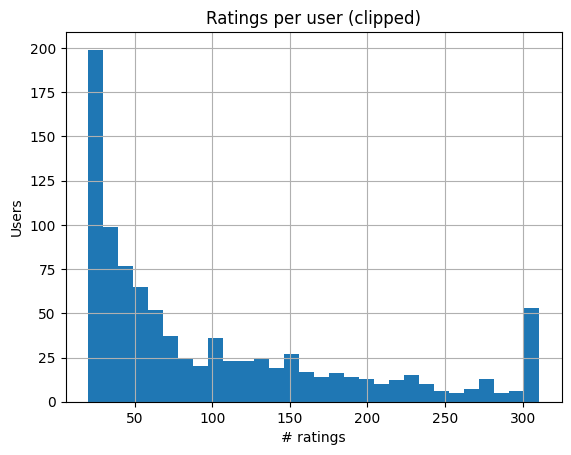

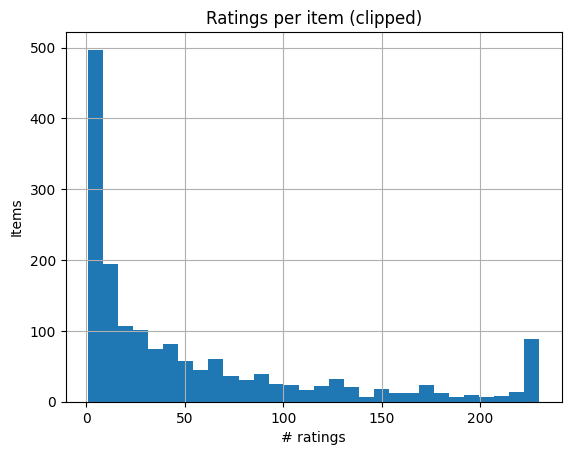

,item_id,title,count
0,50,Star Wars (1977),583
1,258,Contact (1997),509
2,100,Fargo (1996),508
3,181,Return of the Jedi (1983),507
4,294,Liar Liar (1997),485
5,286,"English Patient, The (1996)",481
6,288,Scream (1996),478
7,1,Toy Story (1995),452
8,300,Air Force One (1997),431
9,121,Independence Day (ID4) (1996),429


In [6]:
# Histogram Shows the distribution of explicit rating values (1–5).
# Helps us see if users mostly give high ratings, low ratings, or use the full scale.
plt.figure()
ratings['rating'].hist(bins=np.arange(0.5, 5.6, 1))
plt.title('Ratings distribution'); plt.xlabel('Rating'); plt.ylabel('Count'); plt.show()

# Shows how many ratings each user gives.
# Reveals engagement patterns (most users rate few movies, a few rate many).
user_cnt = ratings.groupby('user_id').size()
plt.figure()
user_cnt.clip(upper=user_cnt.quantile(0.95)).hist(bins=30)
plt.title('Ratings per user (clipped)'); plt.xlabel('# ratings'); plt.ylabel('Users'); plt.show()

# Shows how many ratings each movie/item receives.
# Reveals popularity skew (a few blockbusters get many ratings, most items get few).
item_cnt = ratings.groupby('item_id').size()
plt.figure()
item_cnt.clip(upper=item_cnt.quantile(0.95)).hist(bins=30)
plt.title('Ratings per item (clipped)'); plt.xlabel('# ratings'); plt.ylabel('Items'); plt.show()

# Shows the top 10 most-rated movies by title.
# Identifies the "blockbusters" that dominate user attention and dataset balance.
top_items = (
    item_cnt.sort_values(ascending=False)
            .head(10)
            .rename('count')
            .reset_index()
            .merge(items, on='item_id', how='left')
)

# Show item_id, title, and counts
top_items[['item_id', 'title', 'count']]

# Graph Summary:
# Ratings are skewed toward 4 and 5 stars — users tend to rate positively.
# Most users contribute a small number of ratings, while a minority are “super-raters.”
# A handful of popular movies dominate the rating counts, while most movies are rarely rated (long-tail effect).
# The most-rated movies are well-known blockbusters, confirming the dataset’s popularit

## 4) Prepare data for Surprise

In [7]:
# Surprise needs to know the legal bounds of the explicit rating scale up front.
# It does NOT infer this from the data frame. The bounds are used by algorithms,
# metrics, and sanity checks (they are metadata; Surprise does not auto-clip values).
# Define the rating parser/metadata for explicit 1–5 star ratings.
reader = Reader(rating_scale=(1, 5))

# Build a Surprise Dataset from a 3-column DataFrame ordered as (user, item, rating).
# Column *names* do not matter; the *order* does. Values may be ints or strings (any hashable).
# Heavy lifting (ID remapping, adjacency lists) is deferred until we "build" a Trainset below.
data = Dataset.load_from_df(ratings[['user_id', 'item_id', 'rating']], reader)

# Random 80/20 hold-out at the *interaction* level (not stratified by user/item, not time-aware).
# Returns:
#   - trainset: Surprise Trainset with compact inner IDs and adjacency lists (ur/ir)
#   - testset:  list of (raw_uid, raw_iid, true_rating) tuples for evaluation
# Reproducibility: random_state fixes the split so metrics are stable run-to-run.
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Count interactions in train/test with version-robust logic:
# - Newer Surprise exposes Trainset.n_ratings.
# - Older versions require iterating over trainset.all_ratings().
# This getattr() pattern makes the code forward/backward compatible.
n_train = getattr(trainset, "n_ratings", sum(1 for _ in trainset.all_ratings()))
n_test  = len(testset)

# Note: trainset.n_users / n_items are counts of *entities present in training only*
# after the random split and inner-ID remapping. They may be lower than raw counts if
# some users/items happened to land entirely in the test fold.
print("Train ratings:", n_train, "| Test ratings:", n_test)
print("Users:", trainset.n_users, "| Items:", trainset.n_items)

Train ratings: 80000 | Test ratings: 20000
Users: 943 | Items: 1651


## 5) Train baseline model (SVD)

In [8]:
# --- Instantiate the algorithm ---
# SVD here refers to the "Matrix Factorization with Stochastic Gradient Descent"
# implementation in Surprise (not to be confused with pure linear-algebraic SVD).
# It factorizes the user–item rating matrix into:
#   - User latent factor vectors (size = n_factors)
#   - Item latent factor vectors (size = n_factors)
#   - Bias terms (global mean + user bias + item bias)
# and trains them using SGD to minimize squared error.
algo = SVD(n_factors=50, n_epochs=20, lr_all=0.005, reg_all=0.02, random_state=42)

# --- Train the model on the trainset ---
# trainset is a Surprise-specific Trainset object, with internal user/item ID mapping.
# After this call, algo has learned:
#   - Latent factors for each user and item (up to the ones in trainset)
#   - User and item biases
#   - A global average baseline
algo.fit(trainset)

# --- Evaluate the model on the held-out testset ---
# testset is a list of (user_id, item_id, true_rating) triples in *raw IDs*.
# algo.test(testset) produces a list of Prediction objects, each with:
#   uid, iid, true rating, estimated rating, and extra details (e.g., 'was_impossible').
preds = algo.test(testset)

# --- Compute error metrics ---
# RMSE (Root Mean Squared Error) measures how close predictions are to true ratings.
# Lower RMSE = better rating prediction accuracy.
# Surprise also provides MAE (Mean Absolute Error), but RMSE penalizes large errors more.
rmse = accuracy.rmse(preds)  # prints RMSE and returns it as a float

# --- Display RMSE for reference ---
rmse

# The results of RMSE: 0.9348, 0.934761145254825 means that on average
# the model’s predictions are off by just under 1 star compared to the ground truth.

RMSE: 0.9348


0.934761145254825

## 6) Ranking metrics (Precision@K, Recall@K)

In [9]:
from collections import defaultdict

# Compute macro-averaged Precision@K and Recall@K from Surprise predictions.
def precision_recall_at_k(predictions, k=10, threshold=3.5):

    # Group predictions by user so we can evaluate each user's top-K list independently.
    # user_est_true maps: uid -> list of (estimated_score, true_rating) pairs.
    user_est_true = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))
    precisions, recalls = [], []

    # Evaluate each user independently, then macro-average.
    for uid, user_ratings in user_est_true.items():

        # Sort this user's predicted items by estimated score (descending).
        # After sorting, the first K entries correspond to the model's top-K picks.
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Count how many *truly relevant* items this user has in the full set
        # (based solely on ground truth ratings).
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Count how many items the model *recommends* within the top-K
        # (based solely on predicted score est >= threshold).
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Count how many items in the top-K are BOTH recommended (est>=thr)
        # AND truly relevant (true_r>=thr). This is the set intersection size.
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold)) for (est, true_r) in user_ratings[:k])

        # Precision@K for this user:
        # If the model recommended nothing in top-K (n_rec_k == 0), define precision as 0
        # to avoid division by zero and to reflect "no relevant items found among no recommendations".
        precisions.append(n_rel_and_rec_k / n_rec_k if n_rec_k else 0)

        # Recall@K for this user:
        # If the user has no truly relevant items (n_rel == 0), define recall as 0.
        # This convention avoids inflating averages by users with no positives in ground truth.
        recalls.append(n_rel_and_rec_k / n_rel if n_rel else 0)

    # Macro-average across users (each user contributes equally, regardless of how many ratings they have).
    # Note: This differs from micro-averaging, which would weight by the number of opportunities per user.
    import numpy as np
    return float(np.mean(precisions)), float(np.mean(recalls))

# Compute Precision@10 and Recall@10 at a 3.5-star relevance threshold.
# p10: among items we "surfaced" for each user (top-10), what fraction were truly >= 3.5?
# r10: among each user's truly >= 3.5 items overall, what fraction appeared in the top-10?
p10, r10 = precision_recall_at_k(preds, k=10, threshold=3.5)
print(f"Precision@10: {p10:.3f}  Recall@10: {r10:.3f}")

# Results interpretation:
# Precision@10 = 0.714 → About 7 out of 10 recommended movies are truly relevant (high accuracy).
# Recall@10    = 0.545 → The system surfaces ~55% of all movies a user would have liked (moderate coverage).

Precision@10: 0.714  Recall@10: 0.545


## 7) Top‑N recommendations for any user

In [10]:
# Function: top_n_for_user
# ----------------------------------------
# Purpose:
#   Generate a Top-N recommendation list for a given user using a trained Surprise algo.
# Strategy:
#   1) Map raw user ID -> inner ID used by Surprise.
#   2) Collect items the user has already rated (exclude them from candidates).
#   3) Score all unseen items with algo.predict().
#   4) Sort by predicted score and return the top N with titles.
# Inputs:
#   algo         : a fitted Surprise algorithm (e.g., SVD) with .predict()
#   trainset     : Surprise Trainset (provides ID mappings and user/item histories)
#   user_raw_id  : the raw user identifier as it appears in the ratings data
#   n            : how many recommendations to return (default 10)
# Output:
#   Pandas DataFrame with columns: item_id, title, score (predicted rating)

def top_n_for_user(algo, trainset, user_raw_id, n=10):
    # Map raw user ID to Surprise's internal "inner" user ID
    try:
        inner_uid = trainset.to_inner_uid(user_raw_id)
    except ValueError:
        # If the user never appeared in training, fail explicitly (cold-start user)
        raise ValueError(f"Unknown user id {user_raw_id} in training data.")

    # Collect items this user has already interacted with (inner item IDs)
    # trainset.ur[inner_uid] is a list of (inner_iid, rating) pairs
    seen_inner = {iid for (iid, _) in trainset.ur[inner_uid]}

    # Build the candidate set as all items NOT yet seen by the user
    candidates_inner = [iid for iid in range(trainset.n_items) if iid not in seen_inner]

    # For each candidate item, predict the rating for this user and store (raw_iid, score)
    preds = []
    for inner_iid in candidates_inner:
        # Convert inner item ID back to raw item ID for predict() and final output
        raw_iid = trainset.to_raw_iid(inner_iid)
        # Predict the user's rating; .est is the scalar predicted value
        est = algo.predict(user_raw_id, raw_iid, verbose=False).est
        preds.append((raw_iid, est))

    # Sort candidates by predicted score (descending) to rank best recommendations first
    preds.sort(key=lambda x: x[1], reverse=True)

    # Take the top-N highest-scoring items
    top = preds[:n]

    # Prepare a quick ID->title lookup (if minimal items table is available)
    title_map = items.set_index('item_id')['title'].to_dict() if len(items) else {}

    # Return a tidy DataFrame with item_id, title (if available), and predicted score
    import pandas as pd
    return pd.DataFrame({
        'item_id': [int(i) for i,_ in top],
        'title'  : [title_map.get(int(i)) for i,_ in top],
        'score'  : [float(s) for _,s in top]
    })


# --- Example usage: pick a sample user and fetch Top-10 recommendations ---

# Take the first available inner user ID from the trainset iterator
sample_inner_uid = next(iter(trainset.all_users()))

# Convert that inner user ID back to the raw user ID for prediction/display
sample_raw_uid = trainset.to_raw_uid(sample_inner_uid)

# Print which raw user we are about to recommend for
print("Sample user:", sample_raw_uid)

# Compute Top-10 recommendations for the sample user
top_n_for_user(algo, trainset, sample_raw_uid, n=10)

# For sample user 877, the model’s Top-10 recommendations are mostly highly rated
# classics and critically acclaimed films, each with predicted scores near 4.5–4.7.
# This shows the recommender can generate personalized lists of unseen items that
# align with strong predicted preferences, avoiding movies the user has already rated.

Sample user: 877


,item_id,title,score
0,408,"Close Shave, A (1995)",4.685014
1,64,"Shawshank Redemption, The (1994)",4.653357
2,603,Rear Window (1954),4.606367
3,114,Wallace & Gromit: The Best of Aardman Animatio...,4.585788
4,169,"Wrong Trousers, The (1993)",4.522271
5,513,"Third Man, The (1949)",4.505263
6,478,"Philadelphia Story, The (1940)",4.497729
7,483,Casablanca (1942),4.497494
8,134,Citizen Kane (1941),4.494941
9,512,Wings of Desire (1987),4.481571


## 8) Optional: Hyperparameter search

In [11]:
# --- Step 8: Hyperparameter search with cross-validation ---
# Purpose:
#   Use Surprise's GridSearchCV to tune hyperparameters for the SVD model.
#   The goal is to find the best settings (latent factors, epochs, learning rate, regularization)
#   that minimize RMSE on cross-validated folds.
# Strategy:
#   1) Define a grid of candidate hyperparameters.
#   2) Run 3-fold cross-validation for each combination.
#   3) Report the best RMSE score and the associated parameters.

from surprise.model_selection import GridSearchCV

# Define the hyperparameter search space:
# - n_factors : dimensionality of latent space (20 or 50)
# - n_epochs  : number of training iterations (15 or 25)
# - lr_all    : learning rate for SGD (0.002 or 0.005)
# - reg_all   : L2 regularization strength (0.02 or 0.05)
param_grid = {
    'n_factors': [20, 50],
    'n_epochs' : [15, 25],
    'lr_all'   : [0.002, 0.005],
    'reg_all'  : [0.02, 0.05]
}

# Create the grid search object:
# - Model: SVD (matrix factorization)
# - Grid: param_grid above
# - Measure: RMSE (lower is better)
# - cv=3 means 3-fold cross-validation
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)

# Run the grid search on the full dataset.
# Internally: for each parameter combo, GS builds 3 train/test splits,
# trains an SVD, evaluates RMSE, and averages results.
gs.fit(data)

# Print the best RMSE achieved during search
print(gs.best_score['rmse'])

# Print the parameter combination that produced that best RMSE
print(gs.best_params['rmse'])

# Results interpretation:
# Best RMSE = 0.9368 → predictions are off by just under 1 star on average.
# Best parameters = {n_factors: 50, n_epochs: 25, lr_all: 0.005, reg_all: 0.05}
# What does this mean:
# - n_factors=50 → A richer latent space lets the model capture more subtle user–item patterns.
# - n_epochs=25  → More training passes allow better convergence of those factors.
# - lr_all=0.005 → A higher learning rate speeds convergence without destabilizing training.
# - reg_all=0.05 → Stronger regularization prevents the larger model from overfitting.
# Together: This configuration balances extra model capacity (more factors, more epochs)
# with enough regularization to keep predictions generalizable on new data.

0.9364135903756363
{'n_factors': 50, 'n_epochs': 25, 'lr_all': 0.005, 'reg_all': 0.05}


## 9) Next Steps


1.   Explore SVD++ to incorporate implicit feedback (whether a user rated an item at all).
2.  Add NDCG@K or MAP@K to capture graded relevance and position bias in top-N lists.
3.  Experiment with time-based train/test splits to mimic real-world
4.  Extend with content-aware (hybrid) recommenders by incorporating metadata such as movie genres.


